# Исходные данные

In [1]:
from graph.graph import graph
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.notebook import tqdm

mpl_params = {

    'figure.figsize': (25, 13),
}
plt.rcParams.update(mpl_params)
G = graph.graph

## Палитра цветов
### Палитра узлов

In [2]:
import seaborn

node_palette = seaborn.color_palette('muted', 3)
node_palette

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803)]

### Палитра дуг

In [3]:
edge_palette = seaborn.color_palette('pastel', 3)
edge_palette

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078)]

In [4]:
nodes = G.nodes()
pos = nx.get_node_attributes(G, 'pos')
nodes_types = nx.get_node_attributes(G, 'type')
edges_types = nx.get_edge_attributes(G, 'type')

## Исходный граф
Тип ребер и вершин соответствует типу обслуживаемых беспилотников

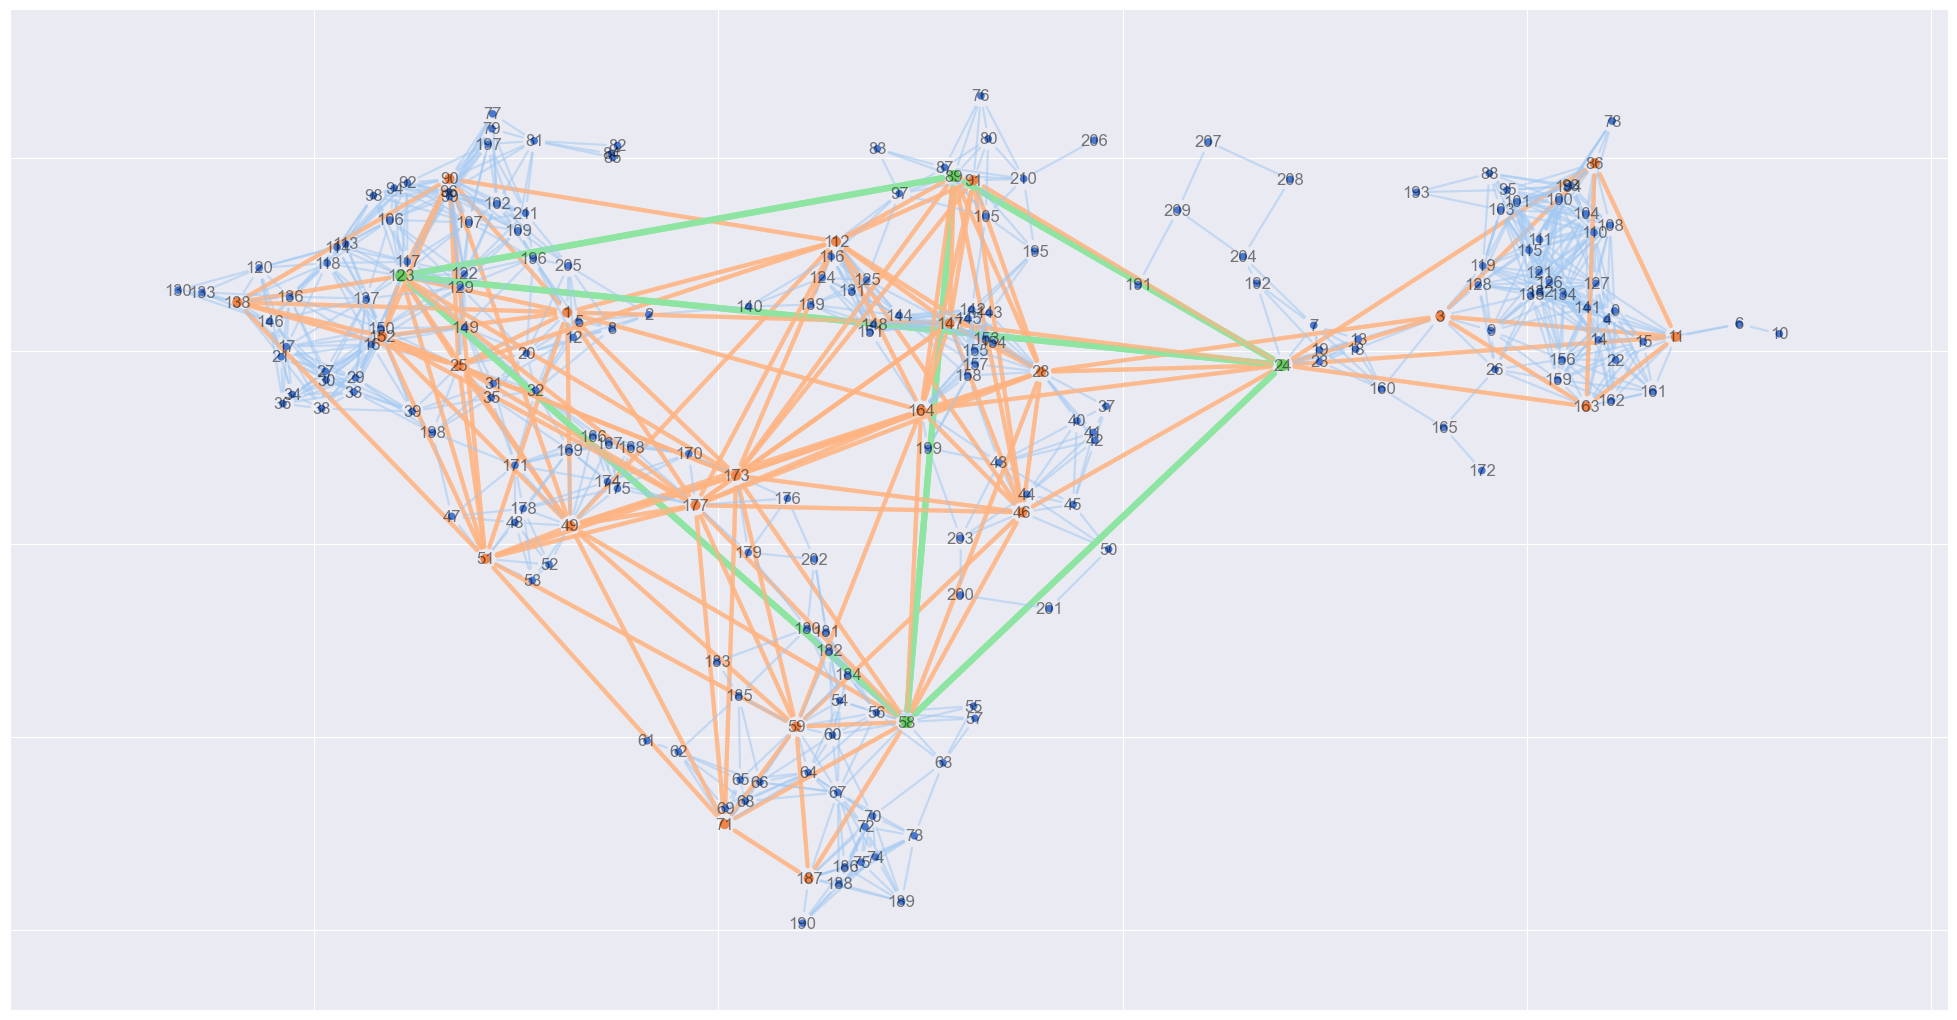

In [5]:
from typing import List

def draw_graph(what: List[str] = None, arrowstyle='-'):
    if what is None or 'edges' in what:
        nx.draw_networkx_edges(G, pos=pos,
                               edge_color=list(map(lambda x: edge_palette[x], edges_types.values())),
                               width=list(map(lambda x: (x + 1) * 1.5, edges_types.values())),
                               alpha=list(map(lambda x: (x + 1) / 3, edges_types.values())),
                               arrows=True,
                               arrowstyle=arrowstyle)
    if what is None or 'nodes' in what:
        nx.draw_networkx_nodes(G, pos=pos,
                               node_color=list(map(lambda x: node_palette[x], nodes_types.values())),
                               node_size=list(map(lambda x: (x + 1) * 20, nodes_types.values())))
    if what is None or 'labels' in what:
        nx.draw_networkx_labels(G, pos=pos,
                                alpha=0.5)


draw_graph()

## Функция стоимости перевозки N грузов на ребрах разных типов
При фиксированном расстоянии

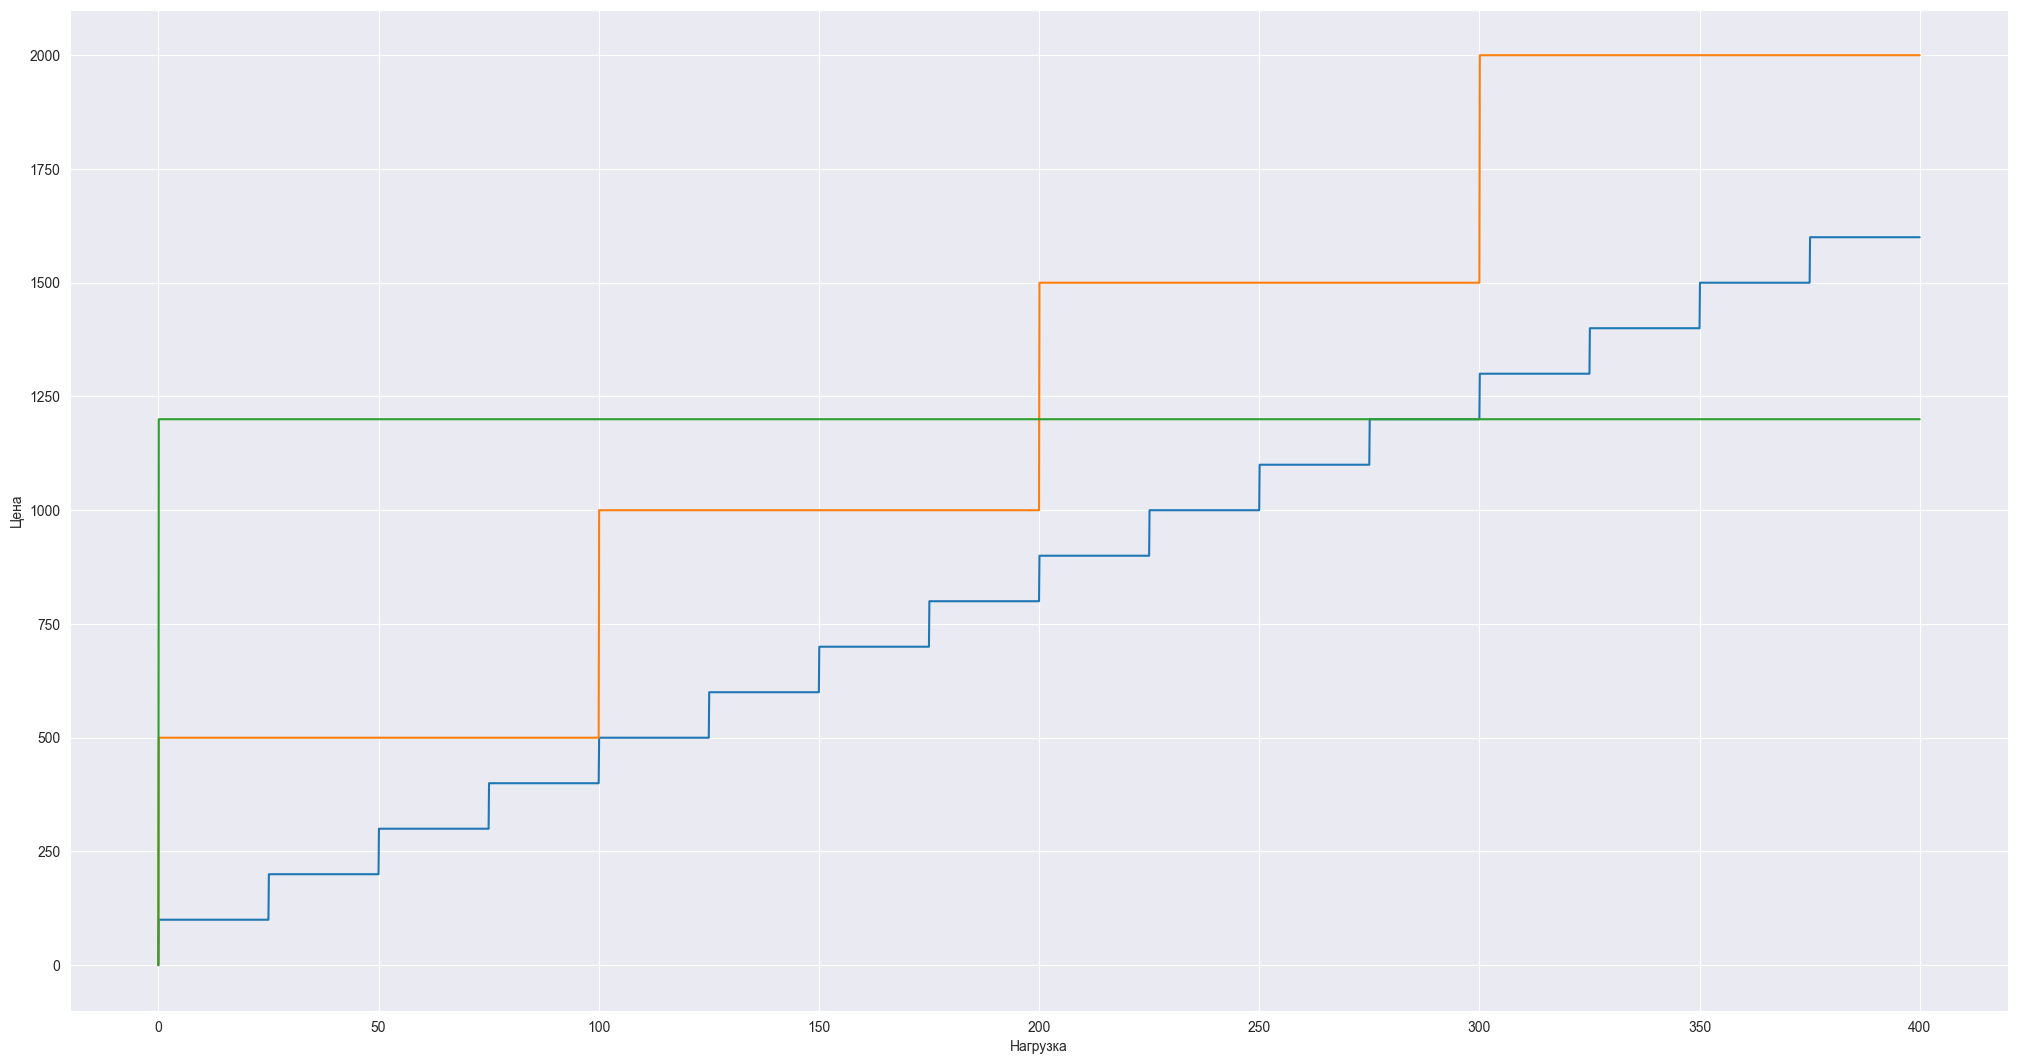

In [6]:
import numpy as np


def draw_price_function(edge_type, dist, max_payload):
    edge_payload = np.arange(-0.01, max_payload, 0.1)
    edge_price = np.array(graph.calc_price(edge_type, dist, edge_payload))
    #
    plt.xlabel('Нагрузка')
    plt.ylabel('Цена')

    plt.plot(edge_payload, edge_price)


draw_price_function(0, 100, 400)
draw_price_function(1, 100, 400)
draw_price_function(2, 100, 400)

## Генерация заказов
А также распределение по размеру партии

(array([7.955e+03, 0.000e+00, 0.000e+00, 9.090e+02, 0.000e+00, 0.000e+00,
        6.900e+01, 0.000e+00, 0.000e+00, 5.000e+00]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

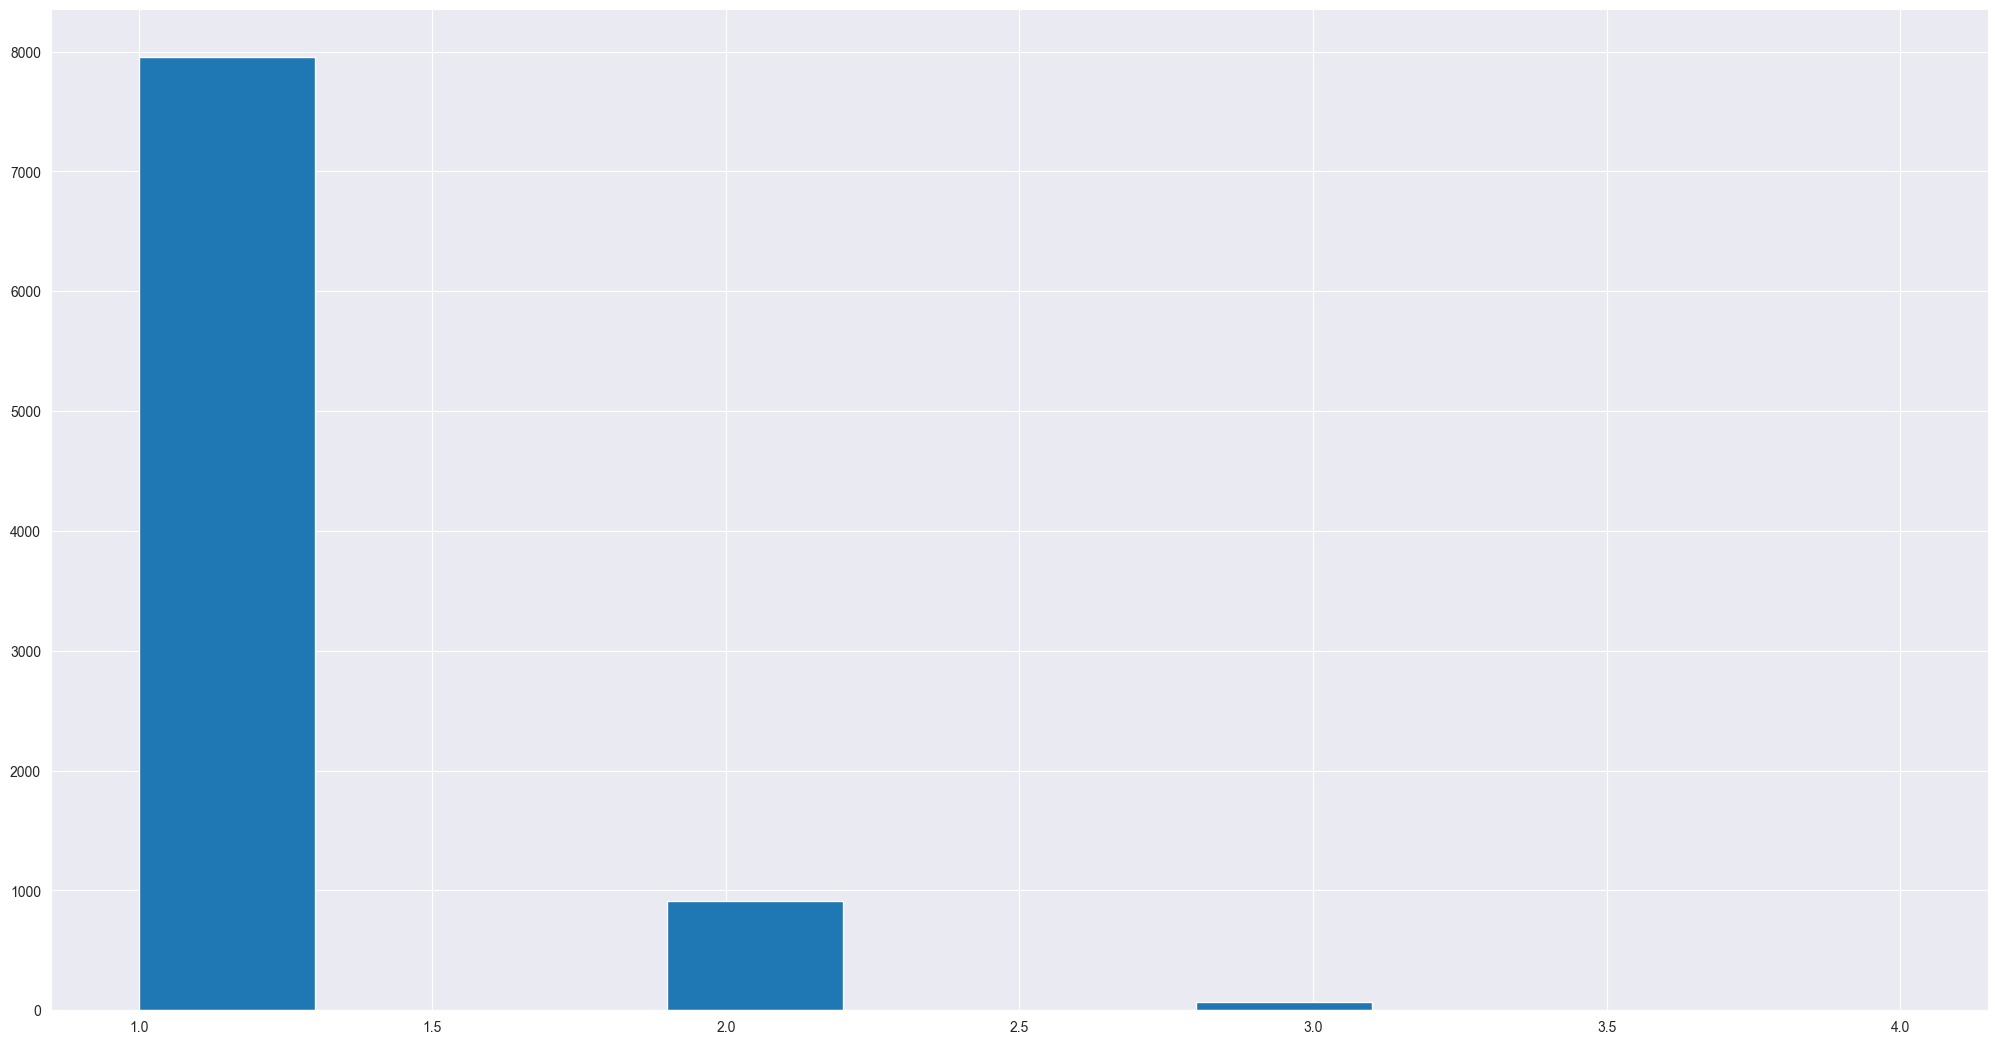

In [9]:
import random
from collections import Counter
random.seed(42)

orders = []
def edges_from_path(p):
    result = []
    for j in range(len(p) - 1):
        result.append((p[j], p[j + 1]))
    return result

for i in range(10000): # 10k
    orders.append(tuple(random.sample(G.nodes(), 2)))
plt.hist(Counter(orders).values())

# Простейший алгоритм планирования путей
Путь для каждого заказа является кратчайшим путем, который формируется на основе априорной информации о длине ребра
## Планирование путей

In [10]:
from itertools import chain
paths = [nx.shortest_path(G, x[0], x[1], 'dist') for x in tqdm(orders)]
used_edges = list(chain(*[edges_from_path(x) for x in tqdm(paths)]))
print('Used edges count: ', len(used_edges))
used_edges_payload = Counter(used_edges)
used_edges_payload

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Used edges count:  49776


Counter({(163, 24): 102,
         (24, 28): 74,
         (6, 11): 85,
         (11, 24): 110,
         (24, 58): 319,
         (58, 63): 87,
         (63, 73): 42,
         (73, 189): 20,
         (70, 67): 58,
         (67, 66): 7,
         (66, 62): 3,
         (57, 58): 39,
         (58, 177): 43,
         (177, 174): 86,
         (174, 169): 26,
         (169, 35): 37,
         (188, 67): 32,
         (67, 58): 163,
         (58, 24): 278,
         (24, 3): 828,
         (3, 26): 33,
         (173, 59): 9,
         (59, 67): 146,
         (67, 74): 65,
         (74, 189): 17,
         (139, 144): 608,
         (144, 147): 495,
         (147, 24): 779,
         (3, 9): 204,
         (9, 156): 137,
         (156, 22): 36,
         (151, 147): 16,
         (3, 128): 386,
         (128, 115): 266,
         (115, 108): 50,
         (8, 2): 83,
         (2, 140): 742,
         (140, 139): 672,
         (24, 7): 38,
         (23, 24): 148,
         (58, 55): 42,
         (59, 49): 127,
  

## Визуализация нагрузки на каждое ребро
Менее прозрачное - более нагруженное

843


  0%|          | 0/1777 [00:00<?, ?it/s]

 ...]

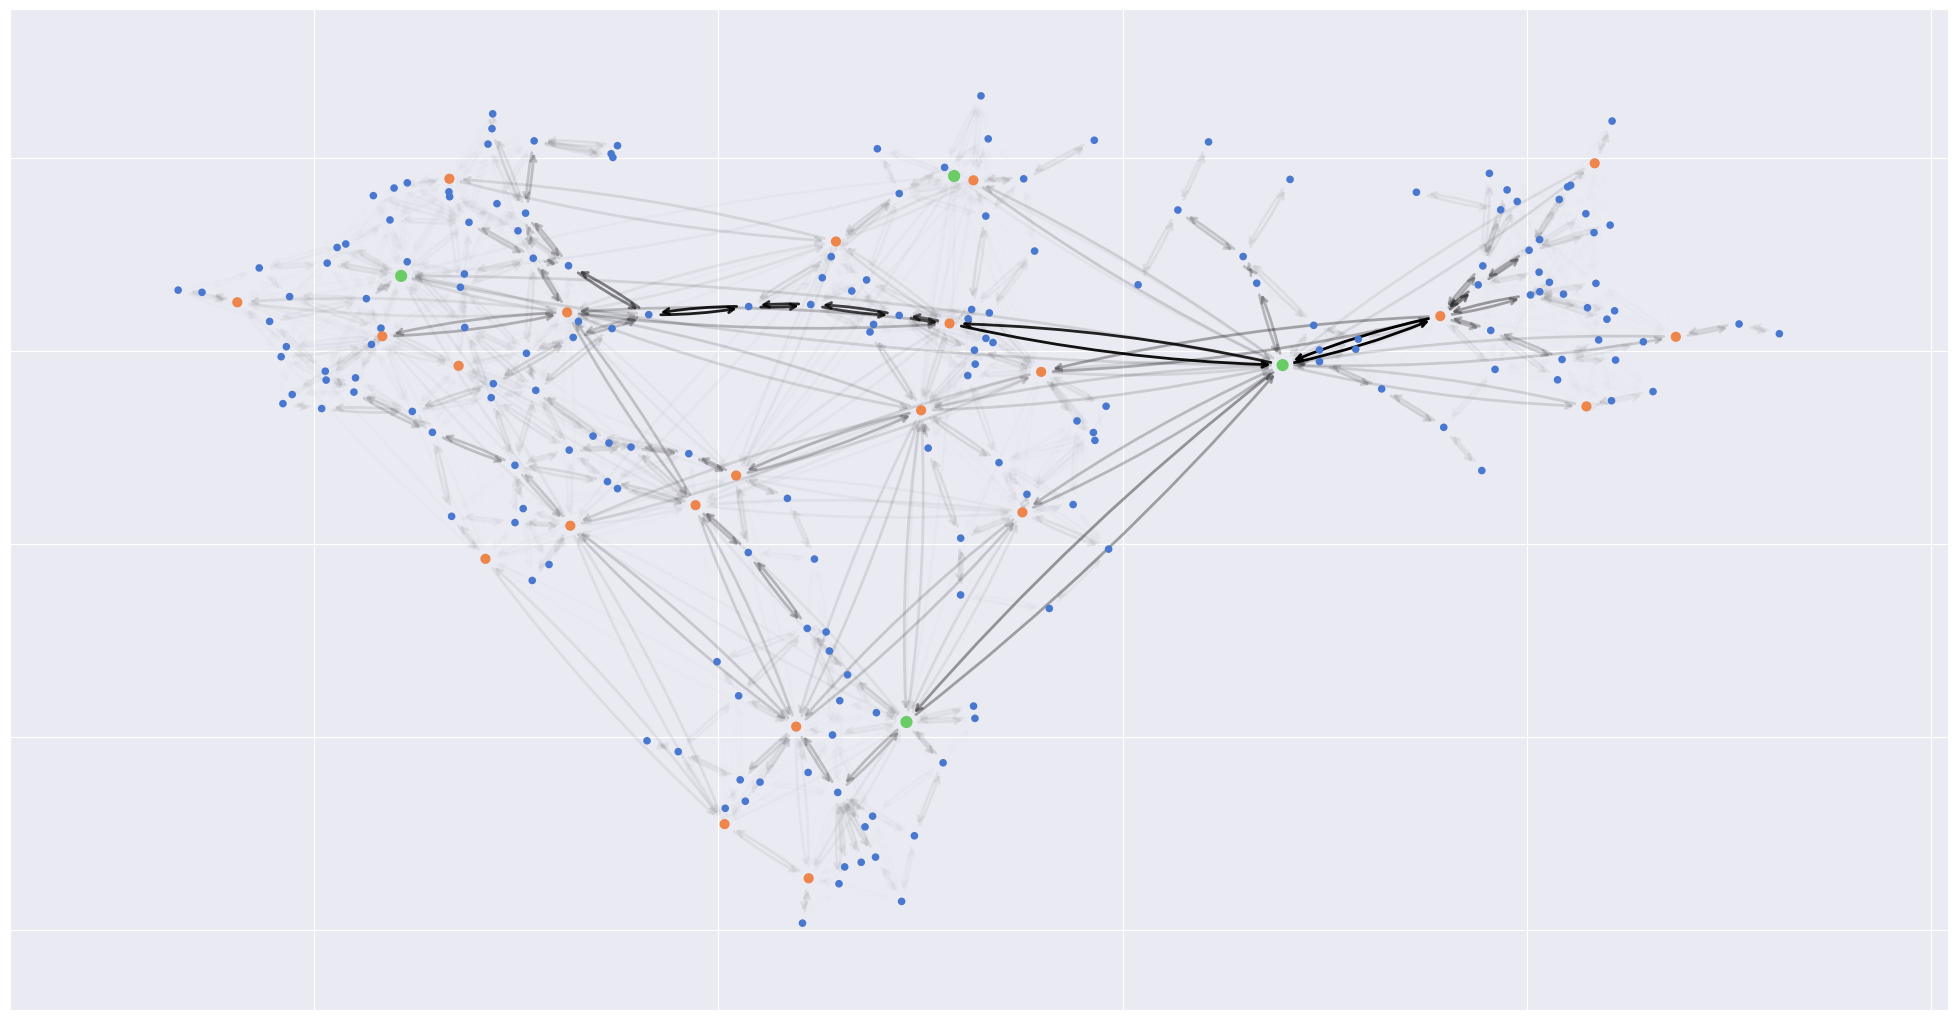

In [11]:
edge_colors = {}
max_edges_payload = max(used_edges_payload.values())
print(max_edges_payload)
for edge, payload in tqdm(used_edges_payload.items()):
    # edge_type = G[edge[0]][edge[1]]['type']
    # edge_colors[edge] = (*node_palette[edge_type], payload / max(used_edges_payload.values()))
    edge_colors[edge] = (0, 0, 0, payload / max_edges_payload)
draw_graph(['nodes'])
nx.draw_networkx_edges(G, pos=pos, arrows=True, width=2, edge_color=edge_colors.values(), edgelist=edge_colors.keys(), connectionstyle='arc3, rad = 0.05', arrowstyle='->')

## Расчет стоимости для данного решения

In [12]:
edge_prices = {}
for edge, payload in tqdm(used_edges_payload.items()):
    edge_attributes = G[edge[0]][edge[1]]
    price = graph.calc_price(edge_attributes['type'], edge_attributes['dist'], payload)
    edge_prices[edge] = price
simplest_algorithm_price = sum(edge_prices.values())
print('Price: ', simplest_algorithm_price)
edge_prices

  0%|          | 0/1777 [00:00<?, ?it/s]

Price:  3114.646834489021


{(163, 24): 15.179745221840783,
 (24, 28): 5.973563927840708,
 (6, 11): 1.27907966913719,
 (11, 24): 19.505245166364794,
 (24, 58): 31.484762600343707,
 (58, 63): 1.113677727172476,
 (63, 73): 0.8082627543070418,
 (73, 189): 0.345842290647055,
 (70, 67): 0.6355841801051949,
 (67, 66): 0.3880913809916421,
 (66, 62): 0.4342628812136689,
 (57, 58): 0.6786535198464796,
 (58, 177): 7.666825972982543,
 (177, 174): 1.809771919331299,
 (174, 169): 0.5001569753587334,
 (169, 35): 0.943742613216125,
 (188, 67): 0.9466786149480758,
 (67, 58): 3.490811218040867,
 (58, 24): 31.484762600343707,
 (24, 3): 36.912762701401775,
 (3, 26): 0.7734697149856524,
 (173, 59): 6.673812047847902,
 (59, 67): 2.3898361533795622,
 (67, 74): 1.151500047763783,
 (74, 189): 0.2632213137266835,
 (139, 144): 11.028010076618546,
 (144, 147): 5.05296744497728,
 (147, 24): 66.45155408265474,
 (3, 9): 2.3424401507829216,
 (9, 156): 2.3010422421155017,
 (156, 22): 0.5290340253707658,
 (151, 147): 0.3960739829880338,
 (3, 128

# Жадный алгоритм
Рекуррентный алгоритм, где путь для каждого заказа является кратчайшим путем.
Кратчайший путь формируется на основе апостериорной информации о стоимости перелета по ребру.
Стоимость перелета по ребру формируется исходя из нагрузки на ребро
$$ Price=f(Distance, Edgetype, Payload)$$
Нагрузка на ребро формируется на основе информации об уже запланированных заказах и текущем заказе
$$ Payload = \sum_{i=0}^{Current-1}weight_i + weight_{Current}$$
Последовательность планирования путей формируется либо по мере поступления заказов, либо в случайном порядке
## Вариант 1

### Планирование путей

In [14]:
#fixme модифицировать жадный алгоритм так, чтобы сначала считались просто кратчайшие пути, а затем каждый путь пересчитывался отдельно с учетом фактической стоимости, и путь менялся если стоимость падала
greedy_payload = dict(zip(G.edges, [0] * len(G.edges)))
paths = []
used_edges = []
i = 0
greedy_part = 0.5
for order in tqdm(orders):
    order_prices = {}
    for edge, payload in greedy_payload.items():
        edge_attributes = G[edge[0]][edge[1]]
        predicted_price = graph.calc_price(edge_attributes['type'], edge_attributes['dist'], payload + 1)
        actual_price = graph.calc_price(edge_attributes['type'], edge_attributes['dist'], payload)
        order_price = predicted_price - actual_price
        order_prices[edge] = order_price

    nx.set_edge_attributes(G, order_prices, 'greedy_price')
    path = nx.shortest_path(G, order[0], order[1], 'greedy_price' if i >= (1 - greedy_part) * len(orders) else 'dist')
    paths.append(path)
    path_edges = edges_from_path(path)
    for edge in path_edges:
        greedy_payload[edge] += 1
        used_edges.append(edge)
    i += 1

print('Used edges count: ', len(used_edges))
used_edges_payload = Counter(used_edges)
used_edges_payload


  0%|          | 0/10000 [00:00<?, ?it/s]

Used edges count:  53041


Counter({(163, 24): 99,
         (24, 28): 99,
         (6, 11): 62,
         (11, 24): 99,
         (24, 58): 399,
         (58, 63): 49,
         (63, 73): 24,
         (73, 189): 9,
         (70, 67): 35,
         (67, 66): 12,
         (66, 62): 15,
         (57, 58): 24,
         (58, 177): 34,
         (177, 174): 49,
         (174, 169): 13,
         (169, 35): 20,
         (188, 67): 24,
         (67, 58): 74,
         (58, 24): 399,
         (24, 3): 499,
         (3, 26): 24,
         (173, 59): 7,
         (59, 67): 99,
         (67, 74): 48,
         (74, 189): 11,
         (139, 144): 299,
         (144, 147): 249,
         (147, 24): 399,
         (3, 9): 124,
         (9, 156): 99,
         (156, 22): 21,
         (151, 147): 7,
         (3, 128): 199,
         (128, 115): 124,
         (115, 108): 19,
         (8, 2): 48,
         (2, 140): 389,
         (140, 139): 338,
         (24, 7): 49,
         (23, 24): 646,
         (58, 55): 24,
         (59, 49): 99,
        

### Визуализация нагрузки на каждое ребро

653


  0%|          | 0/2080 [00:00<?, ?it/s]

 ...]

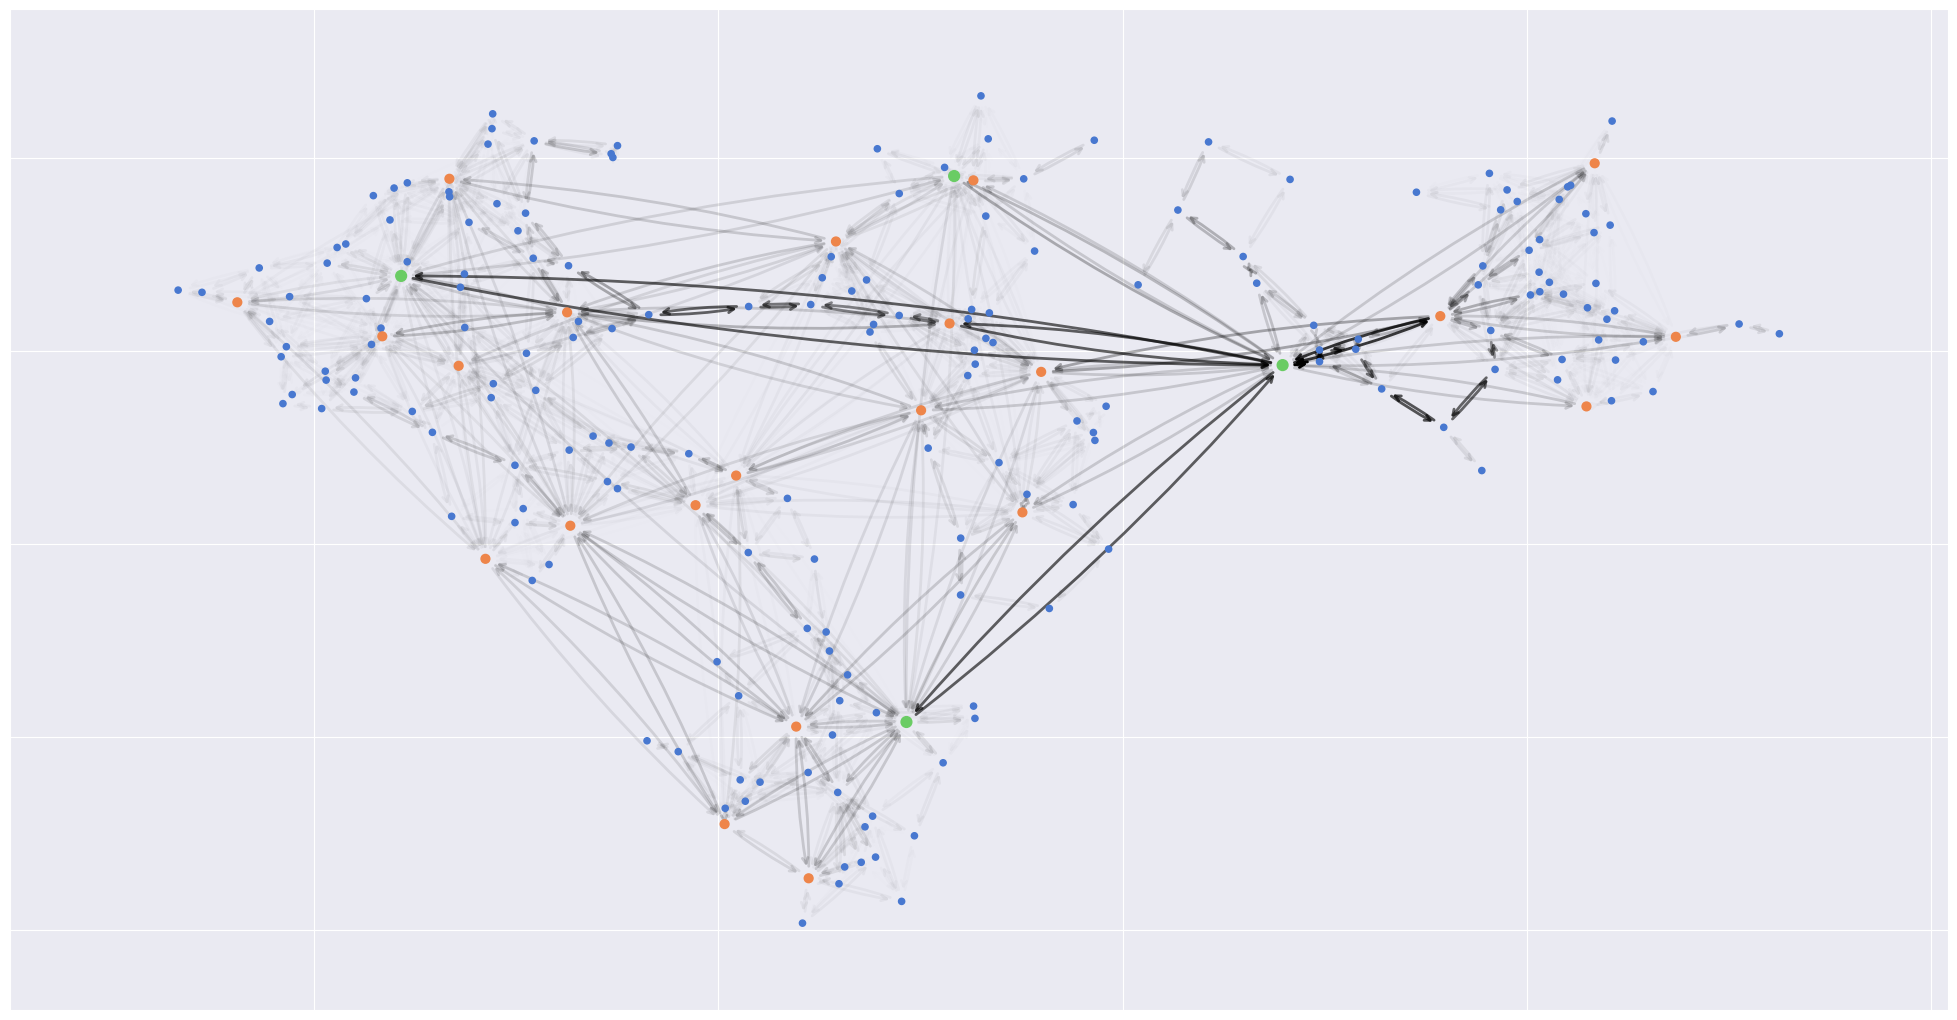

In [15]:
edge_colors = {}
max_edges_payload = max(used_edges_payload.values())
print(max_edges_payload)
for edge, payload in tqdm(used_edges_payload.items()):
    # edge_type = G[edge[0]][edge[1]]['type']
    # edge_colors[edge] = (*node_palette[edge_type], payload / max(used_edges_payload.values()))
    edge_colors[edge] = (0, 0, 0, payload / max_edges_payload)
draw_graph(['nodes'])
nx.draw_networkx_edges(G, pos=pos, arrows=True, width=2, edge_color=edge_colors.values(), edgelist=edge_colors.keys(), connectionstyle='arc3, rad = 0.05', arrowstyle='->')

### Расчет стоимости для данного решения

In [16]:
edge_prices = {}
for edge, payload in tqdm(used_edges_payload.items()):
    edge_attributes = G[edge[0]][edge[1]]
    price = graph.calc_price(edge_attributes['type'], edge_attributes['dist'], payload)
    edge_prices[edge] = price
greedy_algorithm_price = sum(edge_prices.values())
print('Price: ', greedy_algorithm_price)
edge_prices

  0%|          | 0/2080 [00:00<?, ?it/s]

Price:  2855.671742428244


{(163, 24): 7.589872610920391,
 (24, 28): 5.973563927840708,
 (6, 11): 0.9593097518528925,
 (11, 24): 9.752622583182397,
 (24, 58): 31.484762600343707,
 (58, 63): 0.556838863586238,
 (63, 73): 0.4041313771535209,
 (73, 189): 0.345842290647055,
 (70, 67): 0.4237227867367966,
 (67, 66): 0.3880913809916421,
 (66, 62): 0.4342628812136689,
 (57, 58): 0.3393267599232398,
 (58, 177): 7.666825972982543,
 (177, 174): 0.9048859596656496,
 (174, 169): 0.2500784876793667,
 (169, 35): 0.4718713066080625,
 (188, 67): 0.4733393074740379,
 (67, 58): 1.496061950588943,
 (58, 24): 31.484762600343707,
 (24, 3): 20.507090389667653,
 (3, 26): 0.3867348574928262,
 (173, 59): 6.673812047847902,
 (59, 67): 1.5932241022530416,
 (67, 74): 0.7676666985091886,
 (74, 189): 0.2632213137266835,
 (139, 144): 5.293444836776903,
 (144, 147): 2.52648372248864,
 (147, 24): 33.22577704132737,
 (3, 9): 1.3013556393238455,
 (9, 156): 1.5340281614103344,
 (156, 22): 0.2645170126853829,
 (151, 147): 0.3960739829880338,
 (3, 1

## Вариант 2

### Планирование путей

In [18]:
paths = [nx.shortest_path(G, x[0], x[1], 'dist') for x in tqdm(orders)]
orders_paths = dict(zip(orders, paths))
used_edges = list(chain(*[edges_from_path(x) for x in tqdm(paths)]))

used_edges_payload = Counter(used_edges)

paths_final = []
used_edges_final = []
for order, path in tqdm(orders_paths.items()):
    for edge in edges_from_path(path):
        used_edges_payload[edge] -= 1
    order_price_on_edges = {}
    for edge, payload in used_edges_payload.items():
        edge_attributes = G[edge[0]][edge[1]]
        predicted_price = graph.calc_price(edge_attributes['type'], edge_attributes['dist'], payload + 1)
        actual_price = graph.calc_price(edge_attributes['type'], edge_attributes['dist'], payload)
        order_price_on_edge = predicted_price - actual_price
        order_price_on_edges[edge] = order_price_on_edge

    nx.set_edge_attributes(G, order_price_on_edges, 'greedy_price2')
    path = nx.shortest_path(G, order[0], order[1], 'greedy_price2')
    paths_final.append(path)
    path_edges = edges_from_path(path)
    for edge in path_edges:
        used_edges_payload[edge] += 1
        used_edges_final.append(edge)

print('Used edges count: ', len(used_edges_final))
used_edges_payload_final = Counter(used_edges_final)
used_edges_payload_final

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8938 [00:00<?, ?it/s]

Used edges count:  37354


Counter({(163, 3): 21,
         (3, 28): 275,
         (6, 11): 77,
         (11, 24): 176,
         (24, 58): 372,
         (58, 187): 94,
         (187, 189): 23,
         (70, 60): 21,
         (60, 66): 5,
         (66, 62): 8,
         (57, 58): 37,
         (58, 49): 98,
         (49, 25): 62,
         (25, 35): 22,
         (188, 67): 33,
         (67, 58): 156,
         (58, 24): 372,
         (24, 3): 630,
         (3, 26): 47,
         (173, 58): 14,
         (139, 112): 24,
         (112, 28): 99,
         (28, 3): 271,
         (3, 11): 78,
         (11, 22): 24,
         (151, 147): 24,
         (147, 24): 175,
         (24, 86): 93,
         (86, 108): 23,
         (8, 1): 22,
         (1, 123): 82,
         (123, 24): 385,
         (24, 7): 48,
         (23, 24): 67,
         (58, 55): 32,
         (59, 49): 183,
         (49, 1): 75,
         (1, 20): 22,
         (20, 129): 23,
         (154, 28): 22,
         (11, 6): 85,
         (143, 28): 41,
         (28, 46): 45,

### Визуализация нагрузки на каждое ребро

630


  0%|          | 0/1661 [00:00<?, ?it/s]

 ...]

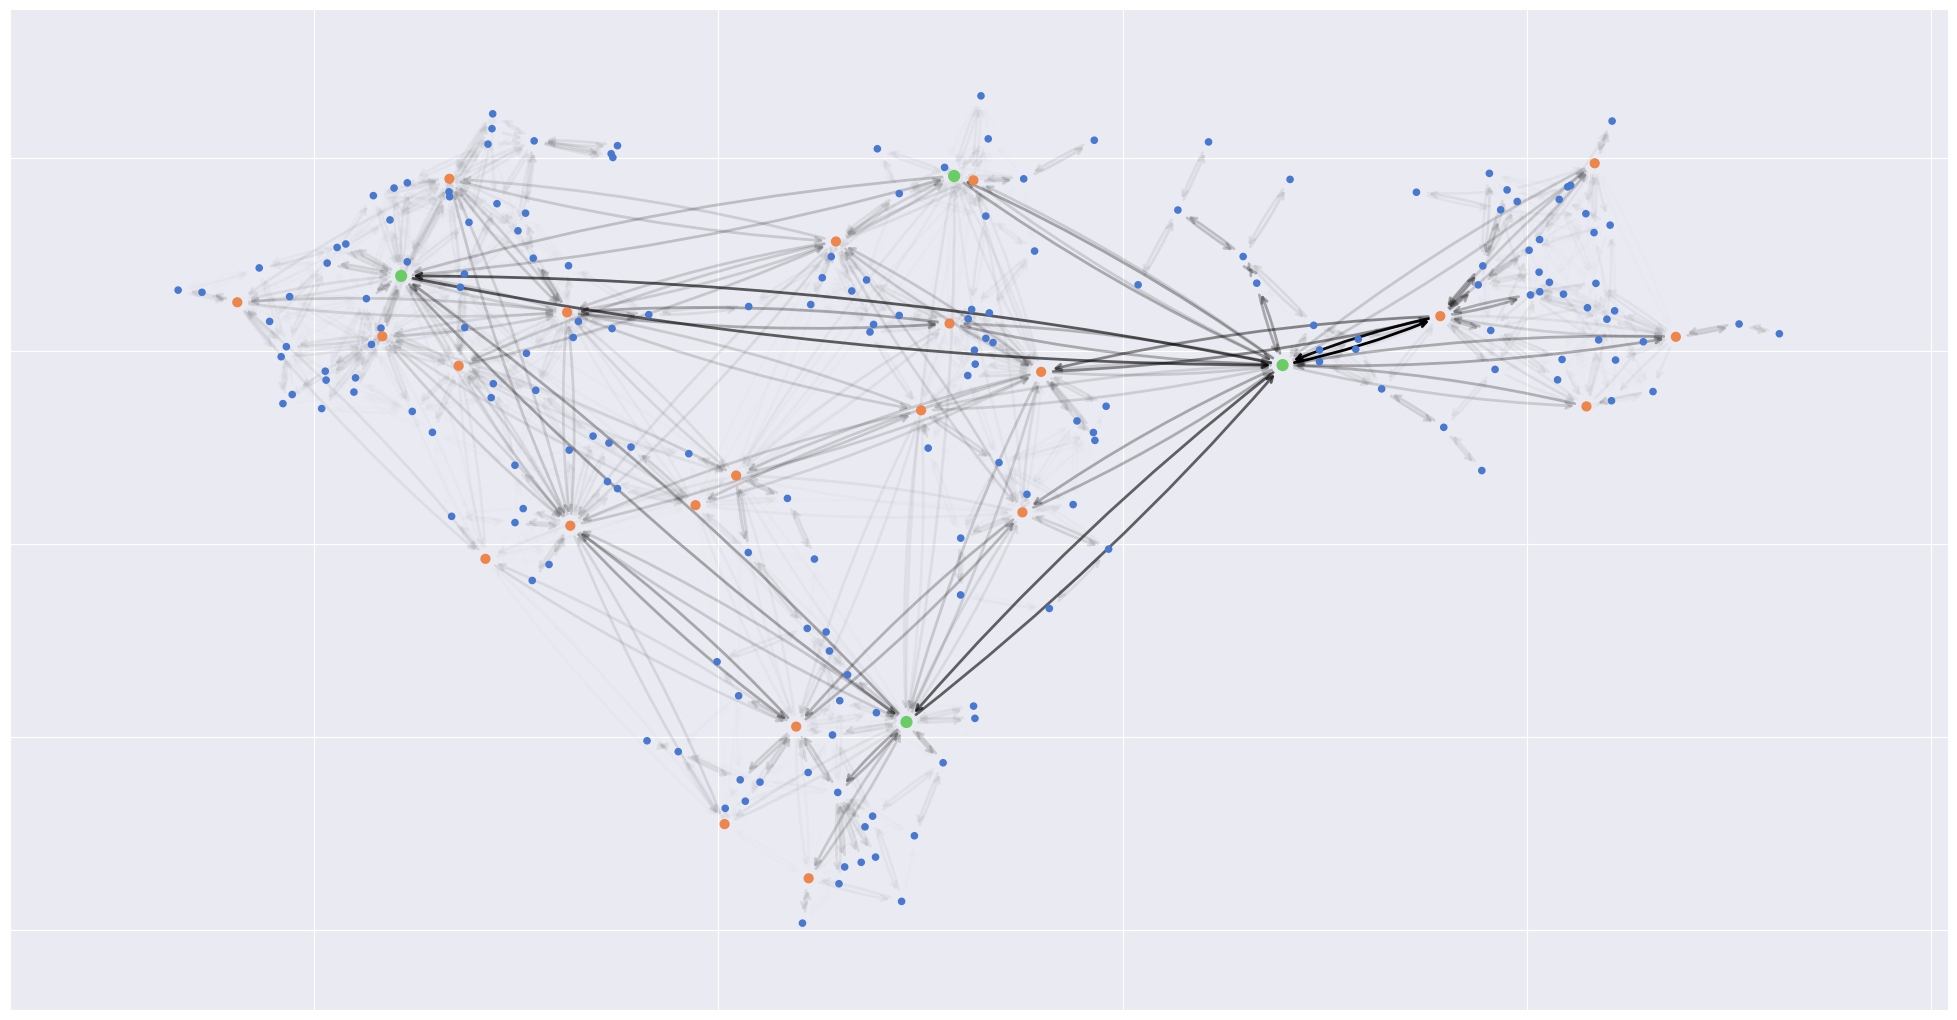

In [19]:
edge_colors = {}
max_edges_payload = max(used_edges_payload_final.values())
print(max_edges_payload)
for edge, payload in tqdm(used_edges_payload_final.items()):
    # edge_type = G[edge[0]][edge[1]]['type']
    # edge_colors[edge] = (*node_palette[edge_type], payload / max(used_edges_payload.values()))
    edge_colors[edge] = (0, 0, 0, payload / max_edges_payload)
draw_graph(['nodes'])
nx.draw_networkx_edges(G, pos=pos, arrows=True, width=2, edge_color=edge_colors.values(), edgelist=edge_colors.keys(), connectionstyle='arc3, rad = 0.05', arrowstyle='->')

### Расчет стоимости для данного решения

In [20]:
edge_prices = {}
for edge, payload in tqdm(used_edges_payload_final.items()):
    edge_attributes = G[edge[0]][edge[1]]
    price = graph.calc_price(edge_attributes['type'], edge_attributes['dist'], payload)
    edge_prices[edge] = price
greedy_algorithm_price = sum(edge_prices.values())
print('Price: ', greedy_algorithm_price)
edge_prices

  0%|          | 0/1661 [00:00<?, ?it/s]

Price:  2591.038112851071


{(163, 3): 4.305414730313403,
 (3, 28): 29.92839773943798,
 (6, 11): 1.27907966913719,
 (11, 24): 19.505245166364794,
 (24, 58): 31.484762600343707,
 (58, 187): 4.717164640968138,
 (187, 189): 0.4751253834515702,
 (70, 60): 0.4653112936518944,
 (60, 66): 0.4337167854718091,
 (66, 62): 0.4342628812136689,
 (57, 58): 0.6786535198464796,
 (58, 49): 9.745784345038599,
 (49, 25): 4.980237193146523,
 (25, 35): 0.2306075670917997,
 (188, 67): 0.9466786149480758,
 (67, 58): 3.490811218040867,
 (58, 24): 31.484762600343707,
 (24, 3): 28.709926545534714,
 (3, 26): 0.7734697149856524,
 (173, 58): 7.650940367039828,
 (139, 112): 0.3499701272966021,
 (112, 28): 6.097265391140522,
 (28, 3): 29.92839773943798,
 (3, 11): 5.849608619386388,
 (11, 22): 0.3217190389143896,
 (151, 147): 0.3960739829880338,
 (147, 24): 16.612888520663684,
 (24, 86): 9.323673364077047,
 (86, 108): 0.3295774870952206,
 (8, 1): 0.2375122102124443,
 (1, 123): 4.211282019765509,
 (123, 24): 52.60970989009543,
 (24, 7): 0.514601

# Генетический алгоритм

##  K кратчайших путей
Для примера - между вершинами 10 и 130
Красным отмечен кратчайший путь

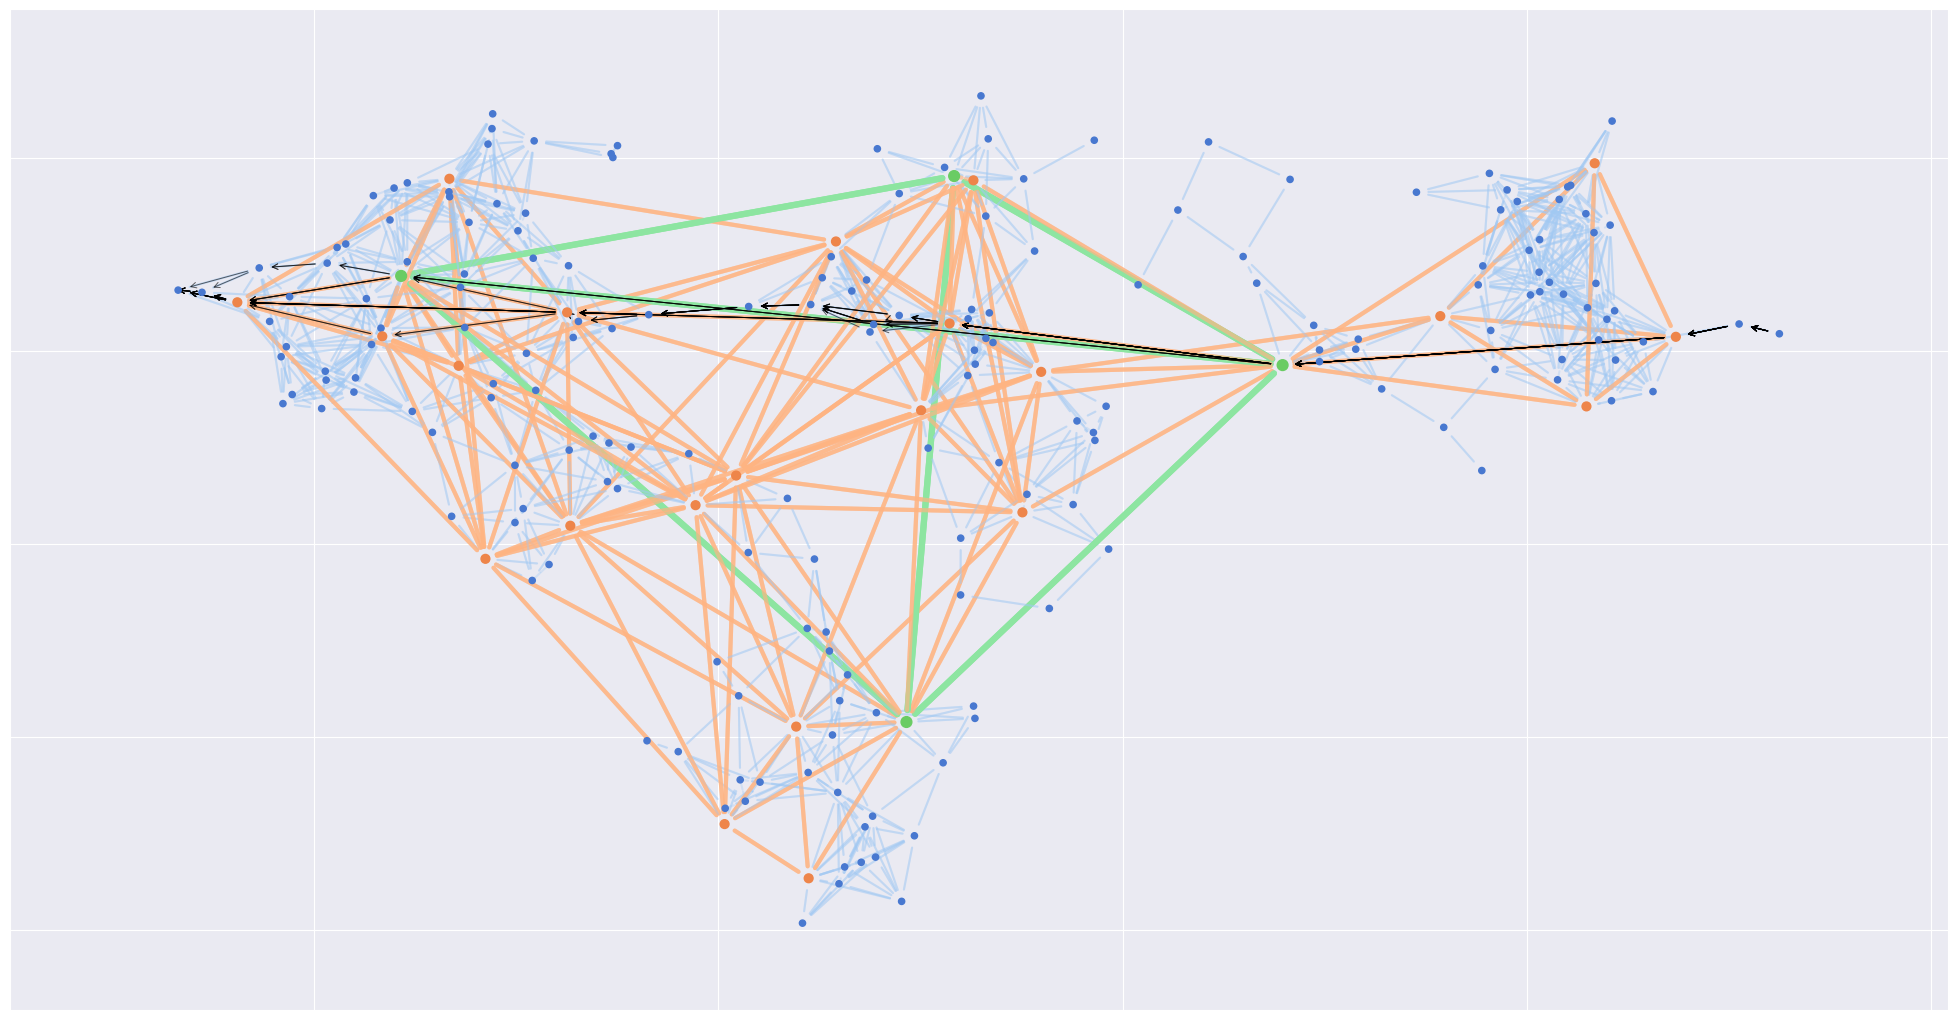

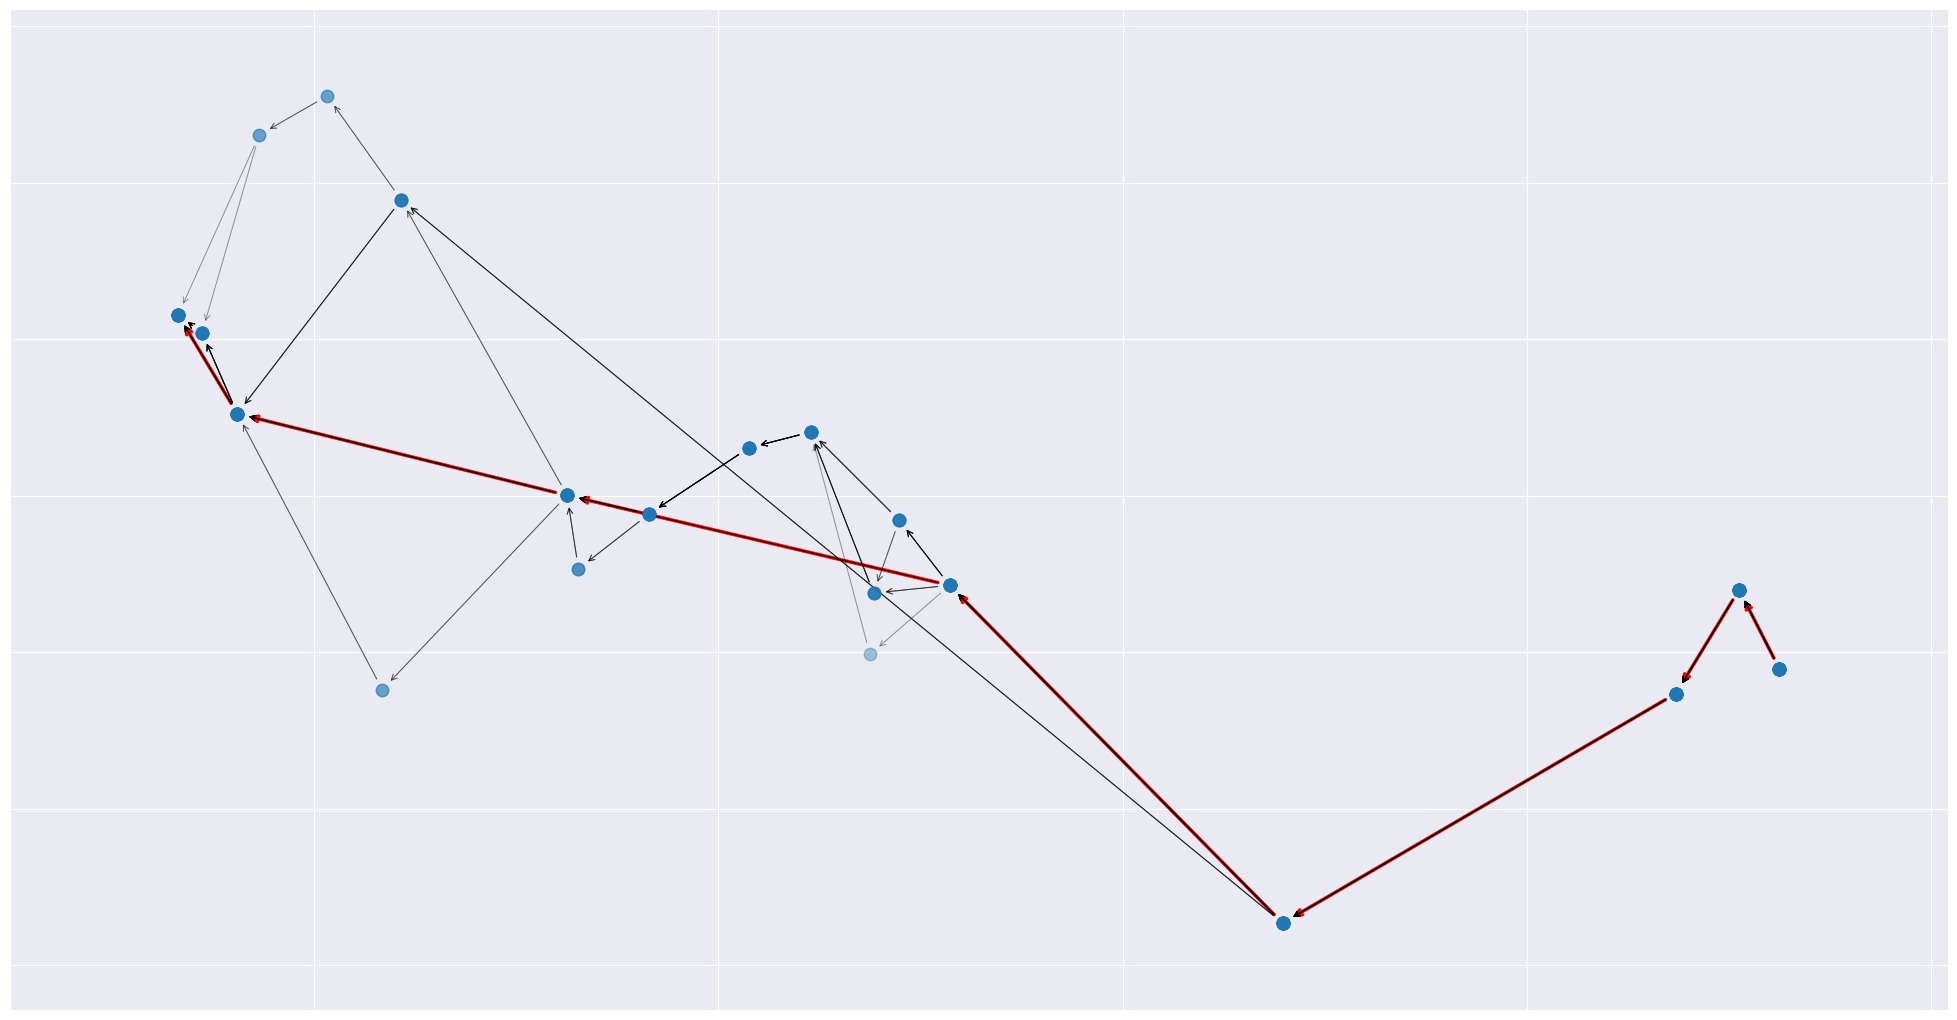

In [14]:

from logistics.k_shortest import k_shortest



paths = k_shortest(G, 10, 130, 'dist')
plt.figure(1)
draw_graph(['nodes', 'edges'])
for path in paths:
    nx.draw_networkx_edges(G, pos=pos, edgelist=edges_from_path(path), alpha=0.6, arrows=True, arrowstyle='->', width=0.7)
plt.figure(2)
for i, path in enumerate(paths):
    nx.draw_networkx_edges(G, pos=pos, edgelist=edges_from_path(path), alpha=1 if i == 0 else 0.4,
                           arrows=True, arrowstyle='->', width=2.5 if i == 0 else 0.7, edge_color='red' if i == 0 else 'k')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=path, alpha=0.4, node_size=80)
    # nx.draw_networkx_labels(G, pos=pos, labels=dict(zip(path, path)), horizontalalignment='left')

## Пространство генов

In [15]:
gene_space = []
for order in tqdm(orders):
    gene_space.append(k_shortest(G, order[0], order[1], 'dist'))

  0%|          | 0/100000 [00:00<?, ?it/s]

## Функция пригодности

In [16]:
def fitness_function(solution, _):
    all_edges = []
    for order_index, order_path_number in enumerate(solution):
        order_path = gene_space[order_index][order_path_number]
        order_edges = edges_from_path(order_path)
        [all_edges.append(x) for x in order_edges]
    all_edges_payload = Counter(all_edges)
    all_edges_prices = {}
    for ed, ed_payload in all_edges_payload.items():
        ed_attributes = G[ed[0]][ed[1]]
        all_edges_prices[ed] = graph.calc_price(ed_attributes['type'], ed_attributes['dist'], ed_payload)
    return 1 / sum(all_edges_prices.values())

In [17]:
import pygad

num_generations = 120
num_parents_mating = 7
sol_per_pop = 50
# num_genes = len(orders)

population = [[0] * len(orders)]
for i in range(sol_per_pop):
    individual = []
    for gene in gene_space:
        individual.append(random.sample(list(range(len(gene))), 1)[0])
    population.append(individual)

last_fitness = 0
def callback_generation(ga_inst):
    global last_fitness
    print("Generation = {generation}".format(generation=ga_inst.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_inst.best_solution()[1]))
    # print("Change     = {change}".format(change=ga_inst.best_solution()[1] - last_fitness))
    print('-----------------------------------')
    last_fitness = ga_instance.best_solution()[1]

gene_space_numeric = list(map(lambda x: list(range(len(x))), gene_space))
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       initial_population=population,
                       on_generation=callback_generation,
                       gene_space=gene_space_numeric,
                       gene_type=int)

Generation = 1
Fitness    = 6.547025864686042e-05
-----------------------------------
Generation = 2
Fitness    = 6.547025864686042e-05
-----------------------------------
Generation = 3
Fitness    = 6.550237760065971e-05
-----------------------------------
Generation = 4
Fitness    = 6.558595017710936e-05
-----------------------------------
Generation = 5
Fitness    = 6.558595017710936e-05
-----------------------------------
Generation = 6
Fitness    = 6.558595017710936e-05
-----------------------------------
Generation = 7
Fitness    = 6.558595017710936e-05
-----------------------------------
Generation = 8
Fitness    = 6.558595017710936e-05
-----------------------------------
Generation = 9
Fitness    = 6.558595017710936e-05
-----------------------------------
Generation = 10
Fitness    = 6.558595017710936e-05
-----------------------------------
Generation = 11
Fitness    = 6.558595017710936e-05
-----------------------------------
Generation = 12
Fitness    = 6.558595017710936e-05
-

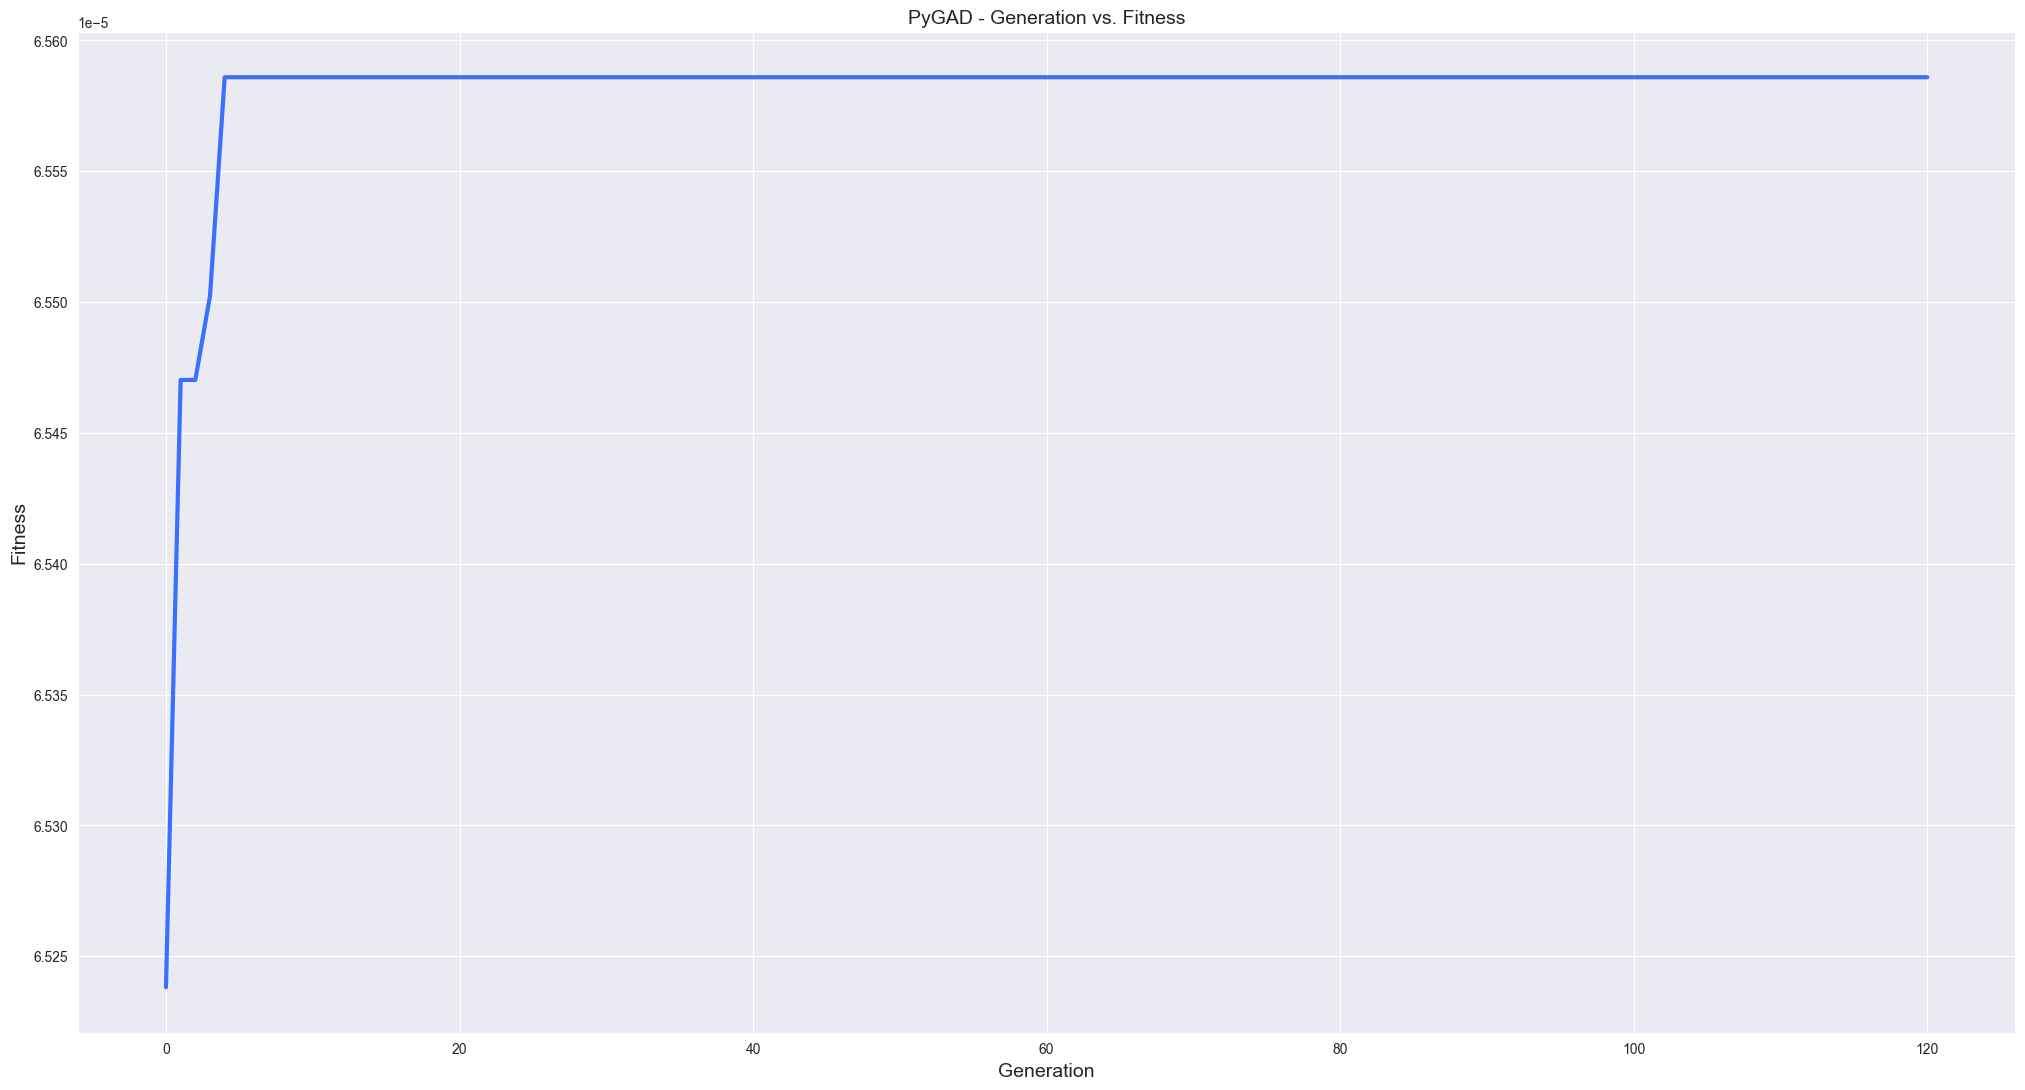

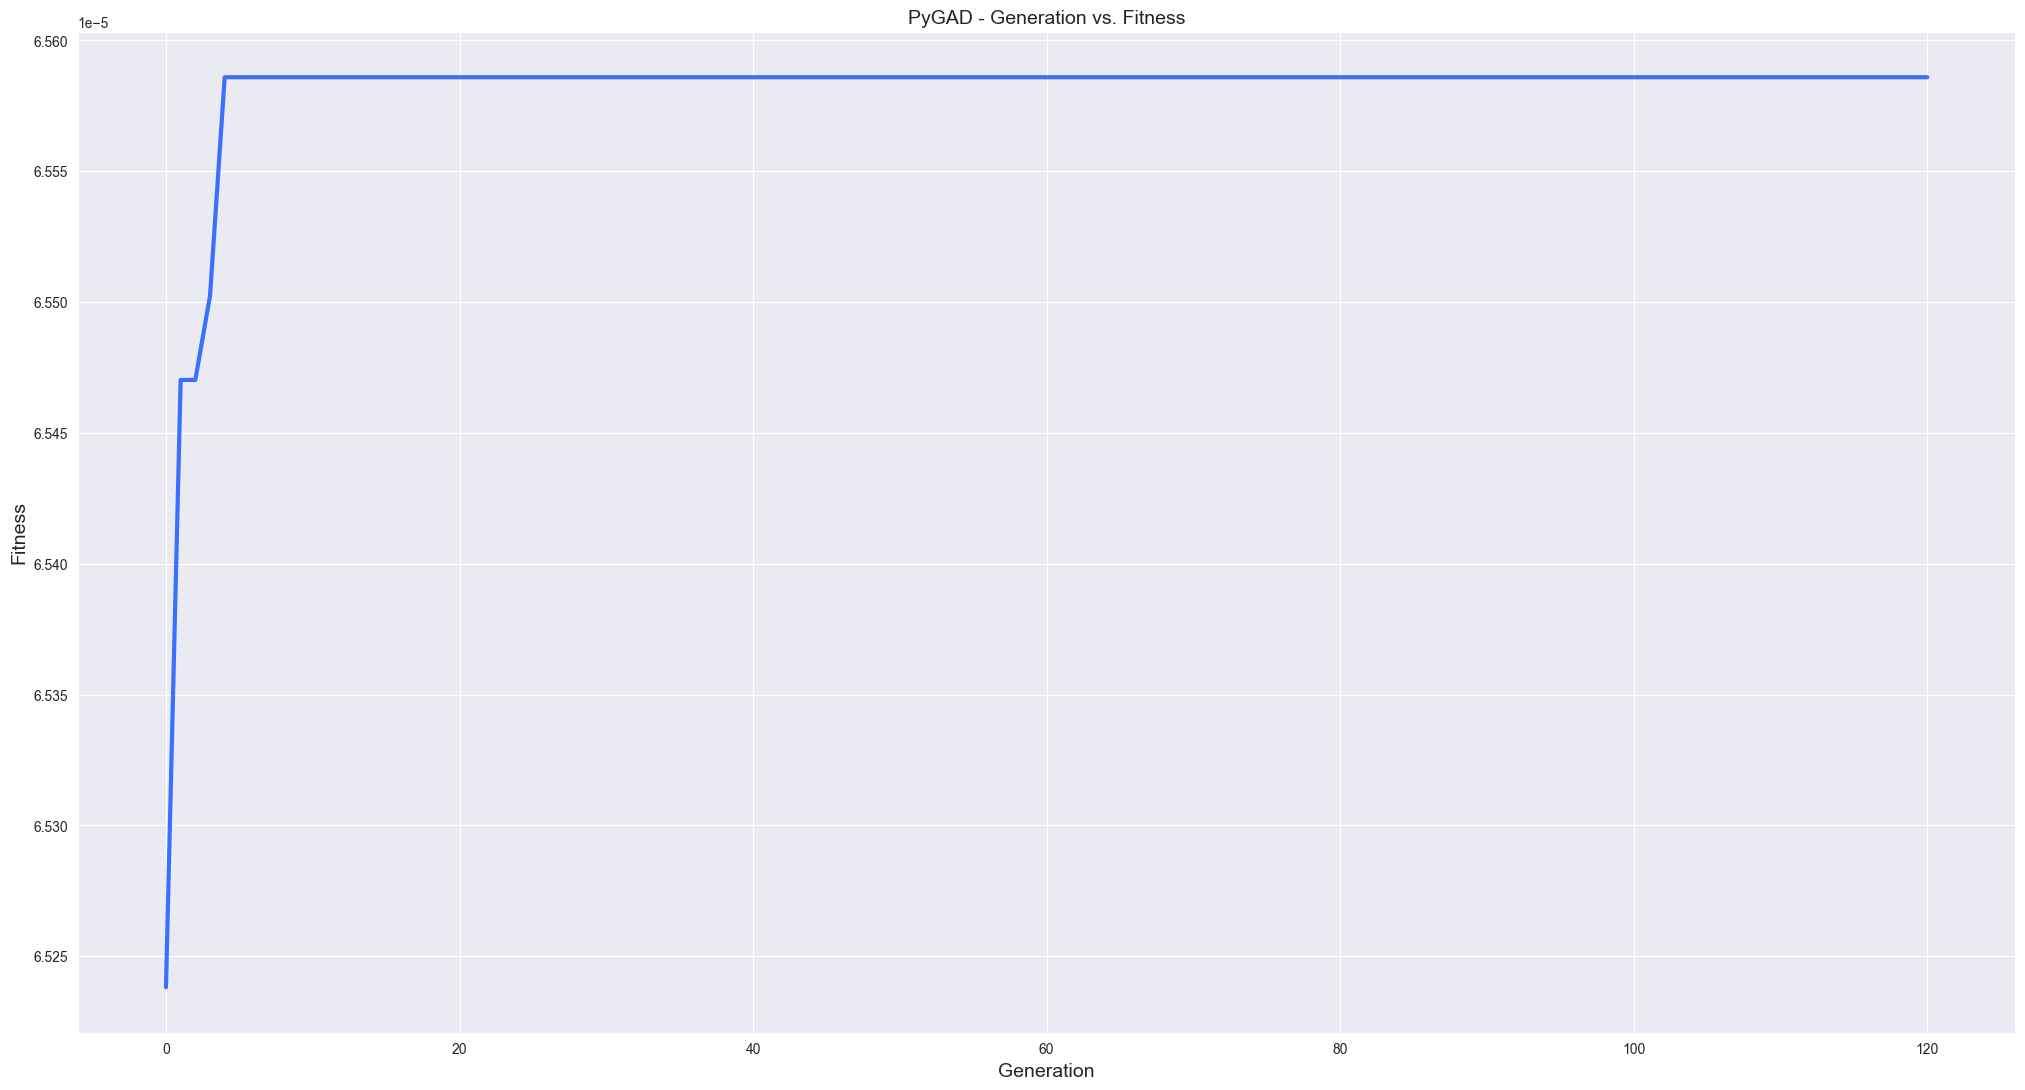

In [18]:
ga_instance.run()
ga_instance.plot_fitness()

## Расчет стоимости для данного решения

In [19]:
1 / ga_instance.best_solution()[1]

15247.16798795449